<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/LMP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install package dependencies (forces restart)
import os

def restart_runtime():
    print('Runtime restarting...')
    os.kill(os.getpid(), 9)

!pip -q install pybullet
!git clone https://github.com/sholtodouglas/pandaRL local_packages/pandaRL
!pip install -e local_packages/pandaRL/.

restart_runtime()

     |████████████████████████████████| 100.8MB 40kB/s 
Cloning into 'local_packages/pandaRL'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 290 (delta 144), reused 230 (delta 88), pack-reused 0
Receiving objects: 100% (290/290), 3.10 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Obtaining file:///content/local_packages/pandaRL
  Running setup.py develop for pandaRL


In [2]:
#@title Workpace Setup (Local vs Colab)
from google.colab import drive, auth
from os.path import join
import os

COLAB = True #@param {type:"boolean"}
DEVICE = "TPU" #@param ["TPU", "GPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
DATASET = "one_obj_play" #@param ["play_data", "one_obj_play"]

if COLAB:
    if DATA_SOURCE == "GCS":
        auth.authenticate_user()
        !gcloud config set project 'learning-from-play'
        ROOT = 'gs://colab-gcs'
        PROJ = 'data/one_obj_play'
        PROJECT_PATH = '/content/data'
        !mkdir /content/data
        !gsutil -m cp -r {ROOT}/{PROJ} {PROJECT_PATH}
    else:
        ROOT = '/content/drive'     # default for the drive
        PROJ = 'My Drive/Robotic Learning'       # path to your project on Drive
        PROJECT_PATH = os.path.join(ROOT, PROJ)
        drive.mount(ROOT)           # we mount the drive at /content/drive
    PYBULLET_DATA_DIR = os.path.join(PROJECT_PATH, DATASET)

    # Sync drive to VM directory
    # !rsync -aP --exclude=data/ "{PROJECT_PATH}/"  '/content/learning_from_play'
    # %cd '/content/learning_from_play'
else:
    # Todo:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! git clone https://github.com/sholtodouglas/learning_from_play



Cloning into 'learning_from_play'...
remote: Enumerating objects: 584, done.
remote: Counting objects: 100% (584/584), done.
remote: Compressing objects: 100% (434/434), done.
remote: Total 584 (delta 208), reused 477 (delta 125), pack-reused 0
Receiving objects: 100% (584/584), 19.79 MiB | 29.33 MiB/s, done.
Resolving deltas: 100% (208/208), done.


In [4]:
%cd '/content/learning_from_play'

/content/learning_from_play


In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [ ]:
!git add .

In [ ]:
!git pull

Already up to date.


In [ ]:
#@title Git config (for commits)
email = "sholto.douglas1@gmail.com" #@param {type:"string"}
name = "sholtodouglas" #@param {type:"string"}

!git config --local user.email "{email}"
!git config --local user.name "{name}"

In [ ]:
#@title Git commit
commit_msg = "Custom loop" #@param {type:"string"}
!git commit -m "{commit_msg}"

[master 245b267] Custom loop
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite output/model_arch/lstm.png (99%)


In [ ]:
#@title Git push
branch = "master" #@param ["master"] {allow-input: true}
!git push origin {branch}

Counting objects: 5, done.
Delta compression using up to 40 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 36.60 KiB | 18.30 MiB/s, done.
Total 5 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/sholtodouglas/learning_from_play.git
   0ba14e0..245b267  master -> master


# Data Creation

In [5]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.3.0
Running on TPU  ['10.92.106.66:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.92.106.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.92.106.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

In [6]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random

import data

In [7]:
# Use this to edit modules without needing to restart the kernel
# import importlib
# importlib.reload(data)

In [8]:
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses']
physical_devices = tf.config.list_physical_devices()
if DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


In [9]:
RELATIVE_JOINTS = True # use relative joints instead of absolute pos/ori as in the orgininal paper

In [10]:
dataset, cnt = data.load_data(PYBULLET_DATA_DIR, keys)

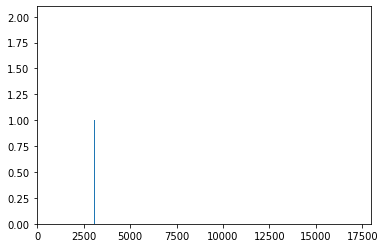

In [11]:
# Histogram of sequence lengths
plt.bar(cnt.keys(), cnt.values(), width=1)
plt.show()

In [12]:
total_frames = sum([x[0]*x[1] for x in cnt.items()])
secs = total_frames / 20
hours = secs // 3600
minutes = secs // 60 - hours * 60
print(f"We have {total_frames} frames of data, which is {hours:.0f}hrs {minutes:.0f}m.")

We have 104802 frames of data, which is 1hrs 27m.


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

class PyBulletRobotSeqDataset():
    def __init__(self, dataset, batch_size=64, seq_len=32, overlap=1.0, 
                 prefetch_size=AUTOTUNE, train_test_split=0.9, relative_joints=False, 
                 variable_seqs=True, seed=42):
        self.N_TRAJS = len(dataset)

        # Split into train and validation datasets
        # List of trajectory dicts
        if train_test_split == 'last': # just use the last set of demos as validation
            self._train_data = dataset[:-1] #[:-1] # raw data - private
            self._valid_data = dataset[-1:]
        else:
            self._train_data = dataset[:int(self.N_TRAJS*train_test_split)] # raw data - private
            self._valid_data = dataset[int(self.N_TRAJS*train_test_split):]
        self.train_data = []
        self.valid_data = []
        self.BATCH_SIZE = batch_size
        self.PREFETCH_SIZE = prefetch_size
        self.OVERLAP = overlap
        self.relative_joints = relative_joints
        self.variable_seqs = variable_seqs

        self.MAX_SEQ_LEN = seq_len ## 40 for example
        self.MIN_SEQ_LEN = seq_len // 2 # so like 20
        if self.relative_joints:
          self.OBS_DIM  = dataset[0]['obs'].shape[-1] + dataset[0]['joint_poses'].shape[-1] 
        else:
          self.OBS_DIM = dataset[0]['obs'].shape[-1]
        if self.relative_joints:
            self.ACT_DIM = dataset[0]['target_poses'].shape[-1] + 1 # +1 for the gripper
        else:
            self.ACT_DIM = dataset[0]['acts'].shape[-1]
            
        self.GOAL_DIM = dataset[0]['achieved_goals'].shape[-1] # 2 objects (xyz quat) + 4 uni dim = 18

        self.random_obj = random.Random(seed)

    def create_goal(self, trajectory, ti, tf):
        return np.tile(trajectory['achieved_goals'][tf, :], (tf-ti,1)) # Be wary of changing this, the planner relies on the fact that final goal is tiled out.

    def traj_to_subtrajs(self, trajectory, idx):
        """
        Converts a T-length trajectory into M subtrajectories of length SEQ_LEN, pads time dim to SEQ_LEN
        """
        T = len(trajectory['obs'])
        frame_skip = max(int(self.MAX_SEQ_LEN*self.OVERLAP),1)
        obs, goals, acts, masks, stored_seq_lens = [], [], [], [], [] # to save us compute time don't calc the seq len from the mask in training. 
        for ti in range(0,T-self.MAX_SEQ_LEN,frame_skip):
            if self.variable_seqs:
              seq_lens = list(self.MAX_SEQ_LEN - np.arange(0, self.MAX_SEQ_LEN-self.MIN_SEQ_LEN, 4)) #create an array of SEQ LENS with spacing 4
              
            else:
              seq_lens = [self.MAX_SEQ_LEN]
            
            for seq_len in seq_lens:
              tf = ti + seq_len
                  
              pad_len = self.MAX_SEQ_LEN-(tf-ti)
              time_padding = ((0,pad_len),(0,0))
              
              if self.relative_joints:
                  rel = trajectory['target_poses'][ti:tf] - trajectory['joint_poses'][ti:tf, :7]
                  gripper = np.expand_dims(trajectory['acts'][ti:tf, -1], -1)
                  action = np.pad(np.concatenate([rel, gripper], -1), time_padding)
                  o = np.concatenate([trajectory['obs'][ti:tf,:],trajectory['joint_poses'][ti:tf,:]],-1).astype('float32')
              else:
                  action = np.pad(trajectory['acts'][ti:tf], time_padding)
                  o = trajectory['obs'][ti:tf,:]
              
              obs.append(np.pad(o, time_padding))
              goals.append(np.pad(self.create_goal(trajectory, ti, tf), time_padding))
              acts.append(action)
              masks.append(np.pad(np.ones(tf-ti), time_padding[0]))
              stored_seq_lens.append([seq_len])

        
        return np.stack(obs), np.stack(goals), np.stack(acts), np.stack(masks), np.stack(stored_seq_lens)

    def create_tf_ds(self, is_training=True):
        """ Converts raw dataset to a shuffled subtraj dataset """
        dataset = self._train_data if is_training else self._valid_data
        obs, goals, acts, masks, seq_lens = [], [], [], [], []
        total_number_of_subtrajs = 0
        for idx, train_sample in enumerate(dataset):
            o,g,a,m,sl = self.traj_to_subtrajs(train_sample, idx)
            obs.append(o)
            goals.append(g)
            acts.append(a)
            masks.append(m)
            
            seq_lens.append(sl)
            total_number_of_subtrajs += len(o)

        

        obs = np.vstack(obs)
        goals = np.vstack(goals)
        acts = np.vstack(acts).astype('float32')
        masks = np.vstack(masks).astype('float32')
        seq_lens = np.vstack(seq_lens).astype('float32')
        print(f'Created {total_number_of_subtrajs} subtrajs')
        ds = tf.data.Dataset.from_tensor_slices((obs, goals, acts, masks, seq_lens)) 
        # Always shuffle, repeat then batch (in that order)
        ds = ds.shuffle(len(obs))
        ds = ds.repeat()
        ds = ds.batch(self.BATCH_SIZE, drop_remainder=True)
        ds = ds.prefetch(self.PREFETCH_SIZE)
        # ds = ds.cache()
        return ds

In [14]:
# Prep the datasets
BATCH_SIZE_PER_REPLICA = 512
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

rsd = PyBulletRobotSeqDataset(dataset, 
                                  batch_size=GLOBAL_BATCH_SIZE, 
                                  seq_len=32, 
                                  overlap=0.01, 
                                  train_test_split=0.9, 
                                  relative_joints=RELATIVE_JOINTS)

# This may take 30s or so depending on the overlap parameter, this takes ~1min with variable seq lens
valid_data = rsd.create_tf_ds(is_training=False)


Created 38272 subtrajs


In [15]:
train_data =  rsd.create_tf_ds(is_training=True)
train_data, valid_data

Created 377224 subtrajs


(<PrefetchDataset shapes: ((4096, 32, 27), (4096, 32, 11), (4096, 32, 8), (4096, 32), (4096, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((4096, 32, 27), (4096, 32, 11), (4096, 32, 8), (4096, 32), (4096, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>)

# Model

In [16]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

## LSTM Model
Use this to map obs -> act

In [17]:
# expected input data shape: (batch_size, timesteps, data_dim)
# Train stateless, inference statefull


class actor(Model):
  def __init__(self, layer_size=1024, p_dropout=0.1, stateful=False, GCBC=False):
    super(actor, self).__init__()
    self.GCBC = GCBC
    self.lstm = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful)
    self.lstm2 = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful)
    self.actions = Dense(rsd.ACT_DIM-1)
    self.gripper = Dense(1,activation="sigmoid")
    
    self.dropout1 = tf.keras.layers.Dropout(p_dropout)
    self.dropout2 = tf.keras.layers.Dropout(p_dropout)

  def call(self, o,z=None,g=None, training = False):
    if self.GCBC:
      x = Concatenate()([o,g])
    else:
      x = Concatenate()([o,z,g])
    x = self.lstm(x)
    x = self.dropout1(x, training=training)
    x = self.lstm2(x)
    x = self.dropout2(x, training=training)
    actions = self.actions(x) # this will be B, T, D
    gripper = self.gripper(x)*0.04 # gripper action scaling
    actions = tf.concat([actions, gripper], axis = -1)
    
    
    return actions

In [18]:
from tensorflow.keras.layers import Bidirectional

def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist


class ENCODER_LSTM(Model):
  def __init__(self, layer_size=1024, latent_dim=256, p_dropout=0.3):
    super(ENCODER_LSTM, self).__init__()

    self.bi_lstm = Bidirectional(LSTM(layer_size, return_sequences=True, return_state=False), merge_mode='concat')
    self.bi_lstm2 = Bidirectional(LSTM(layer_size, return_sequences=True, return_state=False), merge_mode=None)
    self.mu = Dense(latent_dim)
    self.scale = Dense(latent_dim, activation='softplus')
    self.dropout1 = tf.keras.layers.Dropout(p_dropout)
    self.dropout2 = tf.keras.layers.Dropout(p_dropout)

  def call(self, obs, acts, training = False):
    x = tf.concat([obs,acts], axis = 2) # concat observations and actions together.
    x = self.bi_lstm(x)
    x = self.dropout1(x, training=training)
    x = self.bi_lstm2(x)
    bottom = x[0][:,-1, :] # Take the last element of the bottom row
    top = x[1][:,0,:] # Take the first elemetn of the top row cause Bidirectional, top row goes backward.
    x = tf.concat([bottom, top], axis = 1)
    x = self.dropout2(x, training=training)
    mu = self.mu(x)
    s = self.scale(x)
    dist = tfd.Normal(loc=mu, scale=s)
    return dist


def create_planner(layer_size=2048, training=True, epsilon=1e-4, latent_dim = 256):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(rsd.OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    o_g = Input(shape=(rsd.GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate()([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    x = Dense(layer_size, activation="relu", name='layer_4')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)

    
    mixture = tfpl.DistributionLambda(latent_normal,  name='latent_variable')((mu, scale))
    return Model([o_i, o_g], [mixture,mu])

In [19]:
def plot(BETA, steps,  train_act_with_plan_losses, losses, valid_steps, valid_losses, valid_act_with_enc_losses, reg_losses, valid_reg_losses):
  print(f"\n With Beta {BETA}")
  plt.plot(steps[:len(train_act_with_plan_losses)], train_act_with_plan_losses)
  plt.plot(valid_steps[:len(valid_losses)], valid_losses)
  plt.plot(valid_steps[:len(valid_act_with_enc_losses)], valid_act_with_enc_losses)
  plt.plot(steps[:len(losses)], losses)
  plt.legend(['train_plan', 'valid_plan', 'valid_enc', 'train_enc'])
  plt.show()
      
  plt.plot(steps, reg_losses)
  plt.plot(valid_steps[:len(valid_reg_losses)], valid_reg_losses)
  plt.legend(['train_kl', 'valid_kl'])
  plt.show()


# Training Loop

In [20]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
# from tensorflow.distribute import DistributedDataset
KL = tfp.distributions.kl_divergence
import time
import tensorflow_addons as tfa


In [21]:
# Explore regularising the encoder using info-VAE, while concurrently making the planner chase it

In [22]:

LAYER_SIZE = 1024
LATENT_DIM = LAYER_SIZE//8
BETA = 0.1
with strategy.scope():
    # Keras .fit API
  #loss_fn = lambda y, p_y: -p_y.log_prob(y)
  action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
  

  def compute_loss(labels, predictions, mask, seq_lens):
      per_example_loss = action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_regularisation_loss(plan, encoding):
      reg_loss = KL(plan, encoding) #+ KL(encoding, plan)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  train_act_loss = tf.keras.metrics.Mean(name='act_loss')
  valid_act_loss = tf.keras.metrics.Mean(name='valid_act_loss')

  train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
  valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')

  valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
  train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')

  
  model_params = {'layer_size':LAYER_SIZE, 'GCBC':False}
  model = actor(**model_params)

  model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
  encoder = ENCODER_LSTM(latent_dim=LATENT_DIM)
  planner = create_planner(**model_params)

  optimizer = tfa.optimizers.AdamW(1e-4, 2e-4) #tf.keras.optimizers.Adam(2e-4)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

def step(inputs, GCBC=False, training = False):
  (states, goals, actions, mask, seq_lens) = inputs
  if GCBC:
    distrib = model(states, goals=goals, training = training)
    return  compute_loss(actions, distrib, mask, seq_lens), distrib
  else:
  
    encoding = encoder(states, actions, training=training)
    final_goals = goals[:, 0, :]
    plan, _ = planner((states[:, 0, :], final_goals))  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
    if training: # we must expand it out so each input state has a corresponding plan
      z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training=training)
      z_plan = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      plan_acts = model(states, z_plan, goals, training=training)
      train_act_with_plan_loss.update_state(compute_loss(actions, plan_acts, mask, seq_lens))
    
    else:
      # check if encoder is overfitting on validation
      z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      enc_act_distrib = model(states, z_enc, goals, training = training)
      valid_act_with_enc_loss.update_state(compute_loss(actions, enc_act_distrib, mask, seq_lens))

      # true validation performance, w/ planner
      z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training = training) 
      

    action_loss = compute_loss(actions, distrib, mask, seq_lens)
    
    regularisation_loss = compute_regularisation_loss(plan, encoding)
    
    return action_loss, regularisation_loss


# Now outside strategy .scope
def train_step(inputs, GCBC = False):
  with tf.GradientTape() as tape:
    act_loss, reg_loss = step(inputs, GCBC = GCBC, training=True)
    loss = act_loss + reg_loss  * BETA
    
  train_act_loss.update_state(act_loss)
  train_reg_loss.update_state(reg_loss)
  gradients = tape.gradient(loss, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables))
  
  return loss

def test_step(inputs, GCBC=False):
  act_loss, reg_loss = step(inputs, GCBC = GCBC, training=False)
  valid_act_loss.update_state(act_loss)
  valid_reg_loss.update_state(reg_loss)
  return act_loss + reg_loss  * BETA

@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)

@tf.function
def distributed_test_step(dataset_inputs):
  per_replica_losses = strategy.run(test_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)


train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_data.repeat(-1)))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_data.repeat(-1)))




In [23]:
def beta_schedule(steps, BETA_MIN=0.001, BETA_MAX=0.1, step_inc=100):
  # so lets say every 1000 we want to go linearly between 0.001 and 0.1
  steps = steps % step_inc
  BETA = BETA_MIN + steps * (BETA_MAX-BETA_MIN)/step_inc
  return BETA

In [24]:

steps = []
losses = []
reg_losses  = []
valid_losses = []
valid_act_with_enc_losses = []
train_act_with_plan_losses = []
valid_steps = []
valid_reg_losses = []
n_steps = 24000
progbar = Progbar(n_steps, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
t = 0

In [31]:

# Repeat datasets indefinitely
n_steps = 30000
while t < n_steps:
    #BETA = 0.1#beta_schedule(t)
    x = next(train_dist_dataset)
    distributed_train_step(x)
    
    if t % valid_inc == 0:
        
        valid_x = next(valid_dist_dataset)
        distributed_test_step(valid_x)

        # validation plotting
        valid_steps.append(t)
        valid_losses.append(valid_act_loss.result())
        valid_reg_losses.append(valid_reg_loss.result())
        valid_act_with_enc_losses.append(valid_act_with_enc_loss.result())
        progbar.add(valid_inc, [('Validation Loss', valid_act_loss.result())])

        # training plots (no need to do it all the time, leads to slow plotting)
        steps.append(t)
        losses.append(train_act_loss.result())
        reg_losses.append(train_reg_loss.result())
        train_act_with_plan_losses.append(train_act_with_plan_loss.result())
        
        # reset metrics
        valid_act_loss.reset_states()
        valid_reg_loss.reset_states()
        train_act_loss.reset_states()
        train_reg_loss.reset_states()
        valid_act_with_enc_loss.reset_states()
        train_act_with_plan_loss.reset_states()

    t += 1

plot(BETA, steps,  train_act_with_plan_losses, losses, valid_steps, valid_losses, valid_act_with_enc_losses, reg_losses, valid_reg_losses)

 5560/24000 [=====>........................] - ETA: 2:14:28 - Validation Loss: 1.6569

KeyboardInterrupt: ignored


 With Beta 0.1


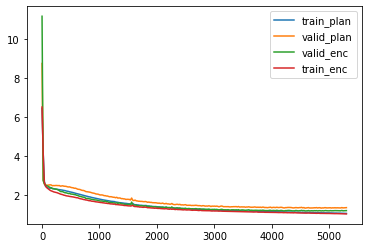

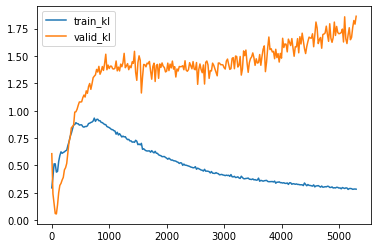

In [28]:
    
plot(BETA, steps,  train_act_with_plan_losses, losses, valid_steps, valid_losses, valid_act_with_enc_losses, reg_losses, valid_reg_losses)

In [29]:
#@title Sample a batch for timeseries plotting
# Lets plot pred actions vs true actions
v_it = iter(valid_data.repeat(-1))
states,goals,acts,masks, seq_lens = v_it.next()
encoding = encoder(states,acts)
plan, _ = planner((states[:, 0, :], goals[:, 0, :])) # TODO this is really aggravating, if we have variable sequence lengths we need to pass
                                                      # Through the indices of the final index, can't just use the last 1, unless we copy it out instead of tiling?
# check if encoder is overfitting on validation
z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
enc_act_distrib = model(states, z_enc, goals)

# true validation performance, w/ planner
z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
pred_acts = model(states, z, goals) # TODO Check can you backprop through samples



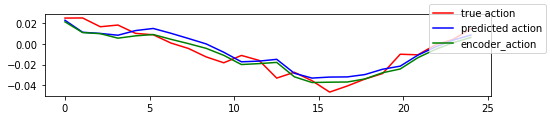

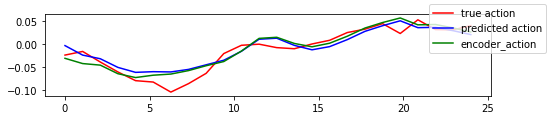

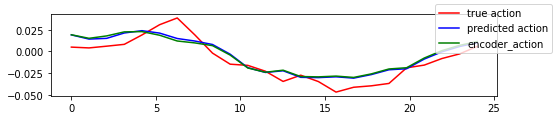

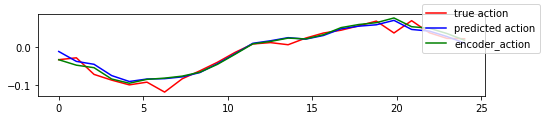

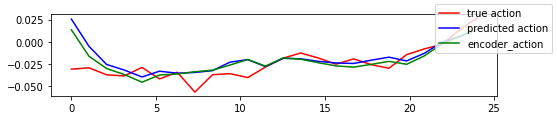

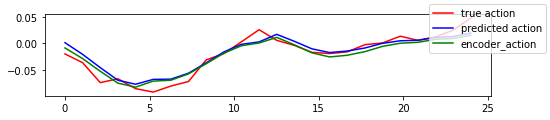

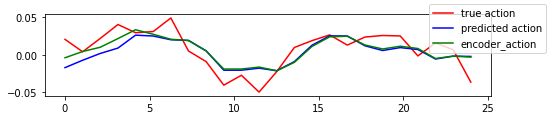

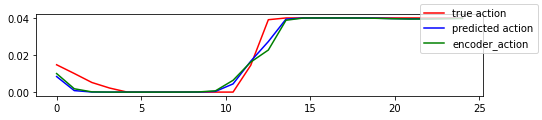

In [37]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
idx = 11
length = int(seq_lens[idx])
actions_space = acts.shape[2]
x = np.linspace(0, length, num=length) 
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(8,1.5), squeeze=False)
    # One Model
    true = axes[0,0].plot(x,acts[idx, :int(seq_lens[idx]),i],'r')
    predicted = axes[0,0].plot(x,pred_acts[idx, :int(seq_lens[idx]),i], 'b')
    enc_predicted = axes[0,0].plot(x,enc_act_distrib[idx, :int(seq_lens[idx]),i], 'g')

    
    fig.legend( ('true action', 'predicted action', 'encoder_action'))
    
    
    plt.show()

In [38]:
def save_weights():
    path = '/content/drive/My Drive/Robotic Learning/LMP_test/'
    try:
      os.makedirs(path)
    except:
      pass

    model.save_weights(path + 'model.h5')
    planner.save_weights(path + 'planner.h5')
    encoder.save_weights(path + 'encoder.h5')

save_weights()

In [ ]:
#@title Explore MMD INFOVAE reg for encoder, with planner chasing it.



<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
def compute_kernel(x, y):
  x_size = tf.shape(x)[0]
  y_size = tf.shape(y)[0]
  dim = tf.shape(x)[1]
  tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
  print(tiled_x, x, y)
  tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
  print(tiled_x.shape, tiled_y.shape)
  return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=2.0/LATENT_DIM):
  x_kernel = compute_kernel(x, x)
  y_kernel = compute_kernel(y, y)
  xy_kernel = compute_kernel(x, y)
  return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

true_samples = tfd.Normal([0.1,0.1,0.1], [1,1,1])
encoding = tfd.Normal([0.1,0.1,0.1], [1,1,1])
loss_mmd = compute_mmd(true_samples.sample(), encoding.sample())


InvalidArgumentError: ignored

In [ ]:


LAYER_SIZE = 512
LATENT_DIM = 256

with strategy.scope():
    # Keras .fit API
  #loss_fn = lambda y, p_y: -p_y.log_prob(y)
  action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

  def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

  def compute_mmd(x, y, sigma_sqr=2.0/LATENT_DIM):
      x_kernel = compute_kernel(x, x)
      y_kernel = compute_kernel(y, y)
      xy_kernel = compute_kernel(x, y)
      return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
  
  def compute_loss(labels, predictions, mask, seq_lens):
      per_example_loss = action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_regularisation_loss(plan, encoding):
      reg_loss = KL(plan, encoding) #+ KL(encoding, plan)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def encoder_regularisation(encoding):
    B = encoding.shape[0]
    true_samples = tf.random_normal(tf.stack([B, z_dim]))
    loss_mmd = compute_mmd(true_samples, encoding.sample())

  train_act_loss = tf.keras.metrics.Mean(name='act_loss')
  valid_act_loss = tf.keras.metrics.Mean(name='valid_act_loss')

  train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
  valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')

  valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
  train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')

  
  model_params = {'layer_size':LAYER_SIZE, 'GCBC':False}
  model = actor(**model_params)

  model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
  encoder = ENCODER_LSTM(latent_dim=LATENT_DIM)
  planner = create_planner(**model_params)

  optimizer = tfa.optimizers.AdamW(1e-4, 2e-4) #tf.keras.optimizers.Adam(2e-4)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

def step(inputs, GCBC=False, training = False):
  (states, goals, actions, mask, seq_lens) = inputs
  if GCBC:
    distrib = model(states, goals=goals, training = training)
    return  compute_loss(actions, distrib, mask, seq_lens), distrib
  else:
  
    encoding = encoder(states, actions, training=training)
    final_goals = goals[:, 0, :]
    plan, _ = planner((states[:, 0, :], final_goals))  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
    if training: # we must expand it out so each input state has a corresponding plan
      z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training=training)
      z_plan = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      plan_acts = model(states, z_plan, goals, training=training)
      train_act_with_plan_loss.update_state(compute_loss(actions, plan_acts, mask, seq_lens))
    
    else:
      # check if encoder is overfitting on validation
      z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      enc_act_distrib = model(states, z_enc, goals, training = training)
      valid_act_with_enc_loss.update_state(compute_loss(actions, enc_act_distrib, mask, seq_lens))

      # true validation performance, w/ planner
      z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
      distrib = model(states, z, goals, training = training) 
      

    action_loss = compute_loss(actions, distrib, mask, seq_lens)
    
    regularisation_loss = compute_regularisation_loss(plan, encoding)
    
    return action_loss, regularisation_loss


# Now outside strategy .scope
def train_step(inputs, GCBC = False):
  with tf.GradientTape() as tape:
    act_loss, reg_loss = step(inputs, GCBC = GCBC, training=True)
    loss = act_loss + reg_loss  * BETA
    
  train_act_loss.update_state(act_loss)
  train_reg_loss.update_state(reg_loss)
  gradients = tape.gradient(loss, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables+encoder.trainable_variables+planner.trainable_variables))
  
  return loss

def test_step(inputs, GCBC=False):
  act_loss, reg_loss = step(inputs, GCBC = GCBC, training=False)
  valid_act_loss.update_state(act_loss)
  valid_reg_loss.update_state(reg_loss)
  return act_loss + reg_loss  * BETA

@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)

@tf.function
def distributed_test_step(dataset_inputs):
  per_replica_losses = strategy.run(test_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)


train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_data.repeat(-1)))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_data.repeat(-1)))

In [ ]:


trial_run(1e-2)
trial_run(1e-3)
trial_run(1e-4)
trial_run(1e-1)

In [ ]:
int(seq_lens[idx])

30

Gradients are "calculated on each replica, they are synced across the replicas by **summing** them"
https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function

In [ ]:
# Keras .fit API
loss_fn = lambda y, p_y: -p_y.log_prob(y)
# loss_fn = MeanSquaredError()

def compute_loss(labels, predictions):
    per_example_loss = loss_fn(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

with strategy.scope():
    model = create_lstm_model_v2(**model_params)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                experimental_steps_per_execution = 2,
                loss=compute_loss,
                metrics=['mean_absolute_error'])

steps_per_epoch = 100
validation_steps = 10

callbacks = [
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    # tf.keras.callbacks.LearningRateScheduler(decay),
]

history = model.fit(train_data,
          epochs=10,
          steps_per_epoch=steps_per_epoch,
          validation_data=valid_data, 
          validation_steps=validation_steps
        #   callbacks=callbacks
          )

Epoch 1/10
 10/100 [==>...........................] - ETA: 3:02 - loss: 979.5474 - mean_absolute_error: 1.1801 

KeyboardInterrupt: ignored

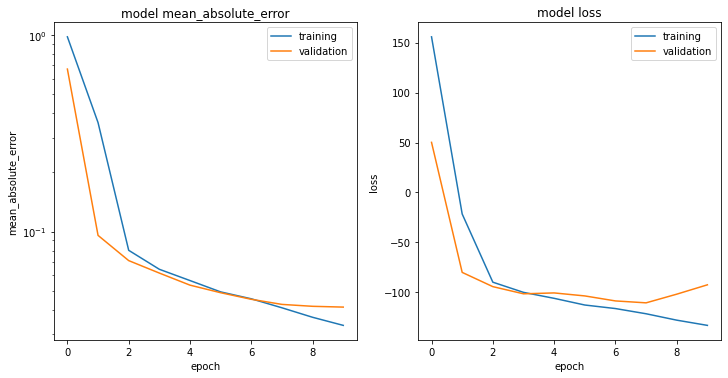

In [ ]:
def display_training_curves(training, validation, title, subplot, yscale='linear'):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])
  plt.yscale(yscale)

plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history.history['mean_absolute_error'], history.history['val_mean_absolute_error'], 'mean_absolute_error', 121, yscale='log')
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 122)

In [ ]:
# For doing custom TPU training loops

# @tf.function
# def train_step(iterator):
#   """The step function for one training step"""

#   def step_fn(inputs):
#     """The computation to run on each TPU device."""
#     images, labels = inputs
#     with tf.GradientTape() as tape:
#       logits = model(images, training=True)
#       loss = tf.keras.losses.sparse_categorical_crossentropy(
#           labels, logits, from_logits=True)
#       loss = tf.nn.compute_average_loss(loss, global_batch_size=batch_size)
#     grads = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
#     training_loss.update_state(loss * strategy.num_replicas_in_sync)
#     # training_accuracy.update_state(labels, logits)

#   strategy.run(step_fn, args=(next(iterator),))

# Eval

In [ ]:
import time
import pandaRL
import gym
import matplotlib.pyplot as plt 
from IPython.display import display, clear_output
import imageio
import eval

if RELATIVE_JOINTS:
  env = gym.make('pandaPlayJoints1Obj-v0')
else:
  env =  gym.make('pandaPlay-v0')
env.reset()
env.render('playback')

current_dir=/content/local_packages/pandaRL/pandaRL/envs
/content/local_packages/pandaRL/pandaRL/envs


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# model.save_weights('/content/drive/My Drive/Robotic Learning/inference_model.h5')

In [ ]:
inference_model = create_lstm_model_v2(**model_params, training=False)
inference_model.set_weights(model.get_weights())
# inference_model.load_weights('/content/drive/My Drive/Robotic Learning/inference_model.h5')

In [ ]:
f = 14 # 51
eval_data = np.load(PYBULLET_DATA_DIR+'/obs_act_etc/'+str(f)+'/data.npz')
potential_start_points = glob.glob(PYBULLET_DATA_DIR+'/states_and_ims/'+str(f)+'/env_states/*.bullet')

observations = eval_data['obs']
achieved_goals = eval_data['achieved_goals']
if RELATIVE_JOINTS:
  joints = eval_data['target_poses'] - eval_data['joint_poses'][:,:7]
  gripper = np.expand_dims(eval_data['acts'][:, -1], -1)
  actions = np.concatenate([joints,gripper], -1) 
else:
  actions = eval_data['acts']

def get_random_start_point(potential_start_points):
    idx = np.random.choice(len(potential_start_points))
    path = potential_start_points[idx]
    tstep = int(path.split("/")[-1].replace('.bullet',''))
    return path, tstep

## Inference Loop

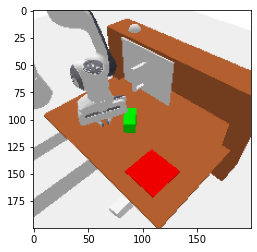

In [ ]:
# Play out action histories
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

vid_path = 'output/videos/trajectory.mp4'
with imageio.get_writer(vid_path, mode='I') as writer:
    for i in range(start, start+60):
        o ,r, d, _ = env.step(actions[i,:])
        writer.append_data(o['img'])
        clear_output(wait=True)
        fig = plt.imshow(o['img'])
        plt.show()
        time.sleep(0.01)

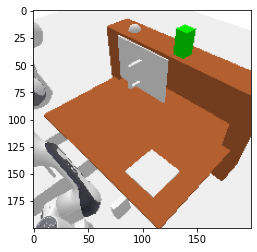

In [ ]:
# Play out stateful model predictions
path, start = get_random_start_point(potential_start_points)
env.p.restoreState(fileName=path)

vid_path = 'output/videos/trajectory.mp4'

eval_seq_len = 60
obs_in = observations[start][tf.newaxis,tf.newaxis,:]
g_in = achieved_goals[start+eval_seq_len][tf.newaxis,tf.newaxis,:] # same as two expand_dims
inference_model.reset_states()

eval_obs = []
eval_acts = []

with imageio.get_writer(vid_path, mode='I') as writer:
    for i in range(start, start+eval_seq_len):
        a = inference_model([obs_in, g_in]).sample()[0,0,:] # Reduce to 1d
        o ,r, d, _ = env.step(a)
        obs_in = o['observation'][tf.newaxis,tf.newaxis,:]
        writer.append_data(o['img'])
        clear_output(wait=True)
        fig = plt.imshow(o['img'])
        plt.show()

        eval_obs.append(o['observation'])
        eval_acts.append(a)
    inference_model.reset_states()

eval_obs = np.vstack(eval_obs)
eval_acts = np.vstack(eval_acts)

In [ ]:
eval.render_mp4(vid_path)

## Plotting Timeseries of obs, acts

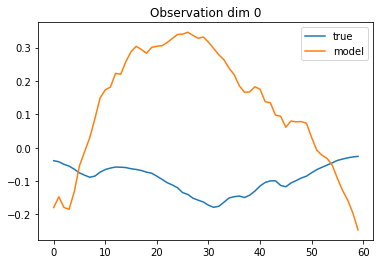

In [ ]:
#@title Visualise observations
obs_idx = 0 #@param {type:"slider", min:0, max:25, step:1}

plt.figure()
t = range(eval_seq_len)
plt.plot(t, observations[start:start+eval_seq_len,obs_idx], label='true')
plt.plot(t, eval_obs[:,obs_idx], label='model')
plt.title(f'Observation dim {obs_idx}')
plt.legend()
plt.show()

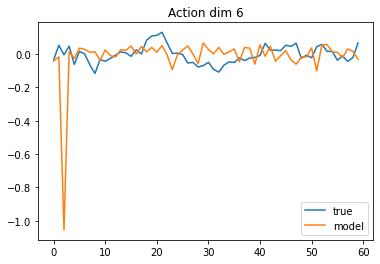

In [ ]:
#@title Visualise actions
acts_idx = 6 #@param {type:"slider", min:0, max:7, step:1}

plt.figure()
t = range(eval_seq_len)
plt.plot(t, actions[start:start+eval_seq_len,acts_idx], label='true')
plt.plot(t, eval_acts[:,acts_idx], label='model')
plt.title(f'Action dim {acts_idx}')
plt.legend()
plt.show()

# Perfect, Deterministic Reset and Replay

In [ ]:
import gym
import time
import pandaRL
if RELATIVE_JOINTS:
    env = gym.make('pandaPlayJoints-v0')
else:
    env = gym.make('pandaPlay-v0')
env.render('human')
env.reset()

In [ ]:
idx = np.random.choice(len(o))
traj_end = len(np.where(m[idx] == 1)[0])-1
#env.panda.reset_goal_pos(ag_to_dg(g[idx, traj_end,:]))
env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')



In [ ]:
for i in range(0, traj_end+1):
    #env.p.restoreState(fileName=dataset_path+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,i]))+'.bullet')
    #time.sleep(0.1)
    env.step(a[idx, i, :])

In [ ]:
def test_subsequences(use_ori = True, replay=False):
    
    t_it = iter(tf_valid_data)
    obs, acts, goals, masks, pth, tsteps = t_it.next()
    idx = np.random.choice(len(obs))
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    
    env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    
    o = tf.expand_dims(obs[idx][0],0)
    
    goal = goals[idx, traj_end,:]
    #env.panda.reset_goal_pos(ag_to_dg(goal))
    goal = tf.expand_dims(goal, 0)
    
    
    if replay:
        retries = 1
    else:
        retries = 1
        
    for i in range(0,retries):
        past_state = [None, None]
        for i in range(0, traj_end+1):

            distrib, past_state = model(o, goal,  past_state = past_state)
            a = distrib.sample().numpy().squeeze() 
            
            if use_ori:
                a[3:7] =  np.array(env.panda.default_arm_orn) # because it hasn't ever had to cope with
            if replay:
                a=acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(o['observation'], 0)

# MLP Evaluation

In [ ]:
def ag_to_dg(ag):
    dg = np.concatenate([ag[0:3], ag[7:10]])
    return dg

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:
valid = dataset[int(N_TRAJS*train_partition):]

def test_subsequences():
    
    obs, acts, goals, masks = sample_sequence_batch(valid)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = np.expand_dims(obs[idx][traj_end][START_GOAL:END_GOAL],0)
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()
    past_state = [None, None]
    
    for i in range(0,3):
        for i in range(0, traj_end+1):
            o = tf.expand_dims(o[START_OBS:END_OBS], 0)
            distrib, past_state = model(o, goal,  past_state = past_state)

            a = distrib.sample().numpy().squeeze() 
            #a = acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            env.render()


In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_goals, traj_init_o, traj_init_v = [valid[idx][key] for key in valid[idx].keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = tf.cast(tf.expand_dims(traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL], 0), tf.float32)
        o = tf.cast(tf.expand_dims(o[START_OBS:END_OBS],0), tf.float32)
        distrib, past_state = model(o,goal, past_state = past_state)
        
        #a = distrib.sample().numpy().squeeze() 
        a = traj_acts[t, :] # uncomment this to replay play subsequences
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)]) 

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])  

88.02201747894287 19.151499032974243


In [ ]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim
registering the liscence


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# MLP Evaluation

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:

def test_subsequences():
    obs, acts, masks = sample_sequence_batch(valid_data)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = obs[idx][traj_end][START_GOAL:END_GOAL]
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()


    past_state = [None, None]

    for i in range(0, traj_end+1):
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()
    

In [ ]:
for i in range(0,100):
    test_subsequences()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])  